# Sentiment Analysis on Airline Tweets Dataset


Sentiment analysis is contextual mining of text which identifies and extracts subjective information in source material and helping a business to understand the social sentiment of their brand, product or service while monitoring online conversations. It is important to classify incoming customer conversation about a brand based on following lines:

1.	 Key aspects of a brand’s product and service that customers care about.
2.	User’s underlying intentions and reactions concerning those aspects.


First of all, we download the dataset from data.world. 
The dataset we acquired contains tweets on US Airline of February 2015 classified in positive, 
negative and neutral tweets. The negative tweets are also classified by the negative reason. 

We then imported all the pacakages required by NLP tasks.


In [ ]:
## Import the library
import numpy as np
import pandas as pd
import preprocessor as p   # tweets preprocessor
import re
import spacy
from contractions import CONTRACTION_MAP
from nltk.tokenize.toktok import ToktokTokenizer
import nltk
from  nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import scale
from sklearn.metrics import roc_curve, auc
import random

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import keras

from sklearn import metrics

import itertools 
import collections
from collections import defaultdict
pd.options.display.max_colwidth = 200


import matplotlib.pyplot as pl
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

We use package NLTK to create a stopwords list, which contains 17 words. 

In [ ]:
## create stopwords list
nlp = spacy.load("en_core_web_md")
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

In [52]:
##Import dataset 
df = pd.read_csv("/Data Science/DSC/Natural Language Processing.bin/dataset/Tweets.csv")

In [53]:
## check the first 2 rows to understand the data structure
df.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials to the experience... tacky.,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


# Exploratory Data Analysis 

By applying Exploratory Data Analysis techniques, we are able to compare the performance for each airline 
measured by the amount positive or negative tweets. 
Furthermore, we can identify what caused the majority of negative reasons at the level of airlines.  

From this chart, we can see this dataset doesn’t have an issue of ‘imbalance”.

In [54]:
## check the distribution of sentiment types
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5, 1.0, 'Sentiment Category Volume Distribution')

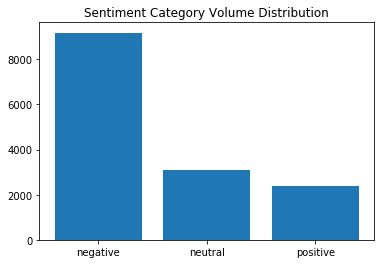

In [139]:
plt.bar(['negative','neutral','positive'],df['airline_sentiment'].value_counts())
plt.title('Sentiment Category Volume Distribution')

In [55]:
## generate 'positive' dataset

df_positive = df[df['airline_sentiment'] == 'positive']
df_positive.shape

(2363, 15)

In [56]:
## generate 'neutral' dataset

df_neutral = df[df['airline_sentiment'] == 'neutral']
df_neutral.shape

(3099, 15)

In [57]:
## generate 'negative' dataset

df_negative = df[df['airline_sentiment'] == 'negative']
df_negative.shape

(9178, 15)

We noticed that the top 3 reasons are Customer Service, Late Flight and Can’t tell.

In [58]:
## check " negative reason" for 'negative' dataset
df_negative.groupby('negativereason')['negativereason'].count().sort_values(ascending=False)

negativereason
Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text xticklabel objects>)

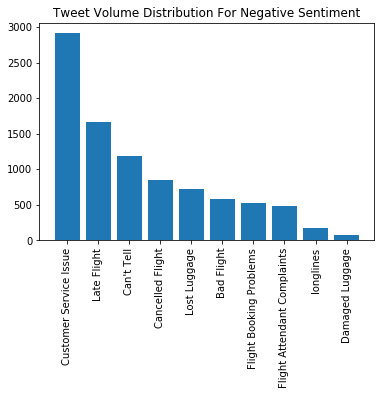

In [149]:
plt.bar(df_negative.groupby('negativereason')['negativereason'].count().sort_values(ascending=False).index,df_negative.groupby('negativereason')['negativereason'].count().sort_values(ascending=False))
plt.title('Tweet Volume Distribution For Negative Sentiment')
plt.xticks(rotation='vertical')

This dataset contains the tweets provided by six airlines: Delta, United, Southwest, American, 
US Airways and Virgin America. To make a comparison between these operators, we will look at how the number 
of tweets distributed under different sentiment categories for all these six airlines.  The chart below indicates
that the Southwest had the best performance in terms of positive tweets; United had the worst performance measured 
by negative tweets.


In [59]:
## check positive review distribution by airlines

df_positive.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
Southwest         570
Delta             544
United            492
American          336
US Airways        269
Virgin America    152
Name: airline, dtype: int64

Text(0.5, 1.0, 'Positive Tweets by Airlines')

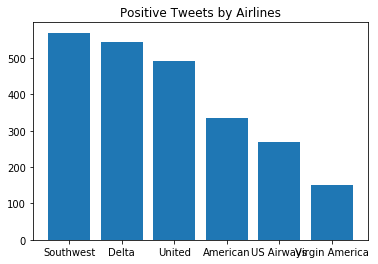

In [145]:
plt.bar(df_positive.groupby('airline')['airline'].count().sort_values(ascending=False).index,df_positive.groupby('airline')['airline'].count().sort_values(ascending=False))
plt.title("Positive Tweets by Airlines")


In [60]:
##  check negative review distribution by airlines
df_negative.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
United            2633
US Airways        2263
American          1960
Southwest         1186
Delta              955
Virgin America     181
Name: airline, dtype: int64

Text(0.5, 1.0, 'Negative Tweets by Airlines')

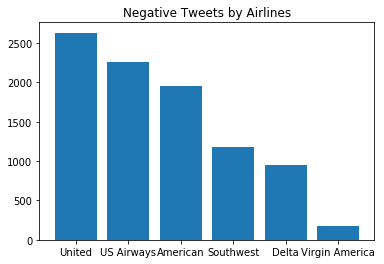

In [146]:
plt.bar(df_negative.groupby('airline')['airline'].count().sort_values(ascending=False).index,df_negative.groupby('airline')['airline'].count().sort_values(ascending=False))
plt.title("Negative Tweets by Airlines")

In [61]:
##  check neutral review distribution by airlines

df_neutral.groupby('airline')['airline'].count().sort_values(ascending=False)

airline
Delta             723
United            697
Southwest         664
American          463
US Airways        381
Virgin America    171
Name: airline, dtype: int64

Text(0.5, 1.0, 'Neutral Tweets by Airlines')

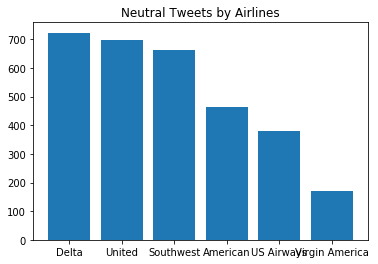

In [147]:
plt.bar(df_neutral.groupby('airline')['airline'].count().sort_values(ascending=False).index,df_neutral.groupby('airline')['airline'].count().sort_values(ascending=False))
plt.title("Neutral Tweets by Airlines")


In [62]:
## check missing values 
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

Unlike other machine learning tasks, Natural Language Processing mainly focuses 
on textual data. This means we are not going to take the traditional approaches to visualize the data. 
The package NLTK can help us calculate and view the frequency of each word in the corpus. 
The size of vocabulary is 20,127. The 10 most frequent-ly occurred words 
are '@', '.', 'to', 'I', 'the', '!', '?', 'a', ',', 'for'.
They are either stop words or special words, which will be removed in the stage of 
text preprocessing. The package WordCloud enables us to visualize the occurrence of each word.


In [63]:
##  calculate  and view the frequency of each word

import nltk
from nltk.tokenize import word_tokenize

reviews = df.text.str.cat(sep=' ')
tokens = word_tokenize(reviews)
vocabulary = set(tokens)
print(len(vocabulary))

frequency_dist = nltk.FreqDist(tokens)
sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]

20127


['@',
 '.',
 'to',
 'I',
 'the',
 '!',
 '?',
 'a',
 ',',
 'for',
 'you',
 'united',
 'on',
 '#',
 'and',
 'flight',
 'my',
 'USAirways',
 'AmericanAir',
 'is',
 'in',
 'SouthwestAir',
 'JetBlue',
 'of',
 'it',
 "n't",
 ':',
 'me',
 'have',
 'was',
 'that',
 'your',
 'with',
 "'s",
 'at',
 'not',
 'get',
 'do',
 'be',
 'from',
 'this',
 'http',
 'no',
 'but',
 'are',
 'Cancelled',
 '...',
 'we',
 'an',
 ';']

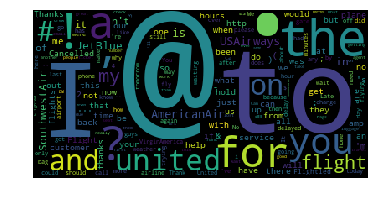

In [64]:
# visulize the frequency distribution of each word

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Train test split

In [65]:
# check the volume distributuon of each category
df['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [66]:
# labelize the target variables
#df['airline_sentiment'] = df['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1})

In [67]:
X_train,X_test,y_train,y_test = train_test_split(df['text'],df['airline_sentiment'],test_size=0.33, random_state=53)

# Text Data Preprocessing
Before we do data visualization and model building, we need to do some data pre-processing or wrangling to remove unnecessary characters, symbols and tokens.  The definition of unnecessary information actually depends on which machine learning techniques to use.


## define some functions

In the English language, contractions are basically shortened versions of words or
syllables. These shortened versions of existing words or phrases are created by 
removing specific letters and sounds. Converting each contraction to its expanded, original form 
often helps with text standardization. For example, the content of 
third row is “@VirginAmerica I didn't today... Must mean I need to take another trip!. 
The step converted “didn’t “ into “did not”. 


In [68]:
## Expand contractions

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

Special characters and symbols which are usually non alphanumeric characters often add to the extra noise 
in unstructured text. More than often, simple regular expressions (regexes) can be used to achieve this. 
In this project, we use the regular 
expression '[^a-zA-z0-9\s]'.

In [69]:
## Remove special characters

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', ' ', text)
    return text

Word stems are usually the base form of possible words that can be created by attaching affixes like prefixes 
and suffixes to the stem to create new words. This is known as inflection. The reverse process of obtaining 
the base form of a word is known as stemming. For example, the words “said” have been converted 
into “say”.

In [70]:
## Lemmatization

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

Words which have little or no significance especially when constructing meaningful features from text are 
known as stopwords or stop words. These are usually words that end up having the maximum frequency if we 
do a simple term or word frequency in a corpus. We use package NLTK to create a stopwords list, 
which contains 17 words. 

In [71]:
## remove stopwords

def remove_stopwords(text):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [72]:
def clean_tweets(df_tmp):
    tempArr = []
    for line in df_tmp:
    #send to tweet_processor
        tmpL = p.clean(line)
        tmpL = expand_contractions(tmpL.lower())
        tmpL = remove_special_characters(tmpL)
        tmpL = lemmatize_text(tmpL)
        tmpL = remove_stopwords(tmpL)
        #remove puctuation
        #tmpL = REPLACE_NO_SPACE.sub("", tmpL) 
        #tmpL = REPLACE_WITH_SPACE.sub(" ", tmpL)
        tempArr.append(tmpL)
    return tempArr

## clean both train/test dataset and the entire dataset 

In [73]:
# clean both train/test dataset and the entire dataset 
X_train_cleaned = clean_tweets(X_train)
X_test_cleaned = clean_tweets(X_test)
X_cleaned = clean_tweets(df['text'])

In [26]:
# check the first lines before cleaning

df['text'][0:5]

0                                                                                               @VirginAmerica What @dhepburn said.
1                                                          @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                           @VirginAmerica I didn't today... Must mean I need to take another trip!
3    @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                           @VirginAmerica and it's a really big bad thing about it
Name: text, dtype: object

In [27]:
# check the first lines after cleaning

X_cleaned[0:5]

['say',
 'plus add commercial experience tacky',
 'not today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guest face amp little recourse',
 'really big bad thing']

## CountVectorization

### Word Counts with CountVectorizer

The CountVectorizer provides a simple way to both tokenize a collection of text documents and
build a vocabulary of known words, but also to encode new documents using that vocabulary. 
For this project, we created a data frame with 6875 columns.


In [28]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_train= count_vectorizer.fit_transform(X_train_cleaned)
count_test= count_vectorizer.transform(X_test_cleaned)

In [29]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())
count_df.head()

,00,000,000419,00a,00am,00p,00pm,0200,03,04,...,zagg,zambia,zcc82u,zero,zig,zip,zipper,zone,zoom,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## TFIDF

One issue with simple counts is that some words will appear many times and their large counts will not be very meaningful in the encoded vectors. An alternative is to calculate word frequencies, and by far the most popular method is called TF-IDF. This stands for “Term Frequency – Inverse Document” Frequency which are the components of the resulting scores assigned to each word.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train_cleaned)
tfidf_test = tfidf_vectorizer.transform(X_test_cleaned)

In [31]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())
tfidf_df.head()

,00,000,000419,00a,00am,00p,00pm,0200,03,04,...,zagg,zambia,zcc82u,zero,zig,zip,zipper,zone,zoom,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#   Traditional Machine Learning Model Building

we created two data frames for CountVectorization and TF-IDF respectively.  
Both of these data frames contain numerical values only.  We can use traditional 
classification machine learning techniques to build predictive models: 

Naïve Bayes multinomial classification and Support Vector classification techniques. 

## Naive Bayes using CountVectorization

In [32]:
nb_classifier = MultinomialNB()
nb_classifier.fit(count_train,y_train)
pred = nb_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.7491721854304636

In [33]:
metrics.confusion_matrix(y_test,pred,labels=nb_classifier.classes_)

array([[2824,  118,   62],
       [ 572,  376,   79],
       [ 316,   65,  420]])

In [34]:
labels = nb_classifier.classes_
conf_df = pd.DataFrame(metrics.confusion_matrix(y_test, pred), columns=labels, index=labels)
conf_df.index.name = 'True labels'

In [35]:
labels

array(['negative', 'neutral', 'positive'], dtype='<U8')

In [36]:
conf_df

,negative,neutral,positive
True labels,,,
negative,2824,118,62
neutral,572,376,79
positive,316,65,420


## Cross validation

In [37]:
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
count_total= count_vectorizer.fit_transform(X_cleaned)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = MultinomialNB()
print(cross_val_score(clf, count_total, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, count_total, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.74385246 0.76639344 0.74385246 0.74043716 0.74248634 0.75887978
 0.75       0.7636612  0.77868852 0.7431694 ]
0.7531420765027323


## SVC using using CountVectorization

In [38]:
svc_classifier = SVC()
svc_classifier.fit(count_train,y_train)
pred = svc_classifier.predict(count_test)
metrics.accuracy_score(y_test,pred)

0.7692466887417219

## Cross validation

In [39]:
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(stop_words='english')
count_total= count_vectorizer.fit_transform(X_cleaned)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, count_total, df['airline_sentiment'], cv=k_fold, n_jobs=1))

print(cross_val_score(clf, count_total, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.7636612  0.77117486 0.77117486 0.76639344 0.77663934 0.76844262
 0.77185792 0.7602459  0.77937158 0.77868852]
0.7707650273224045


## Naive Bayes using Tfidf

In [40]:
nb_classifier = MultinomialNB()
nb_classifier.fit(tfidf_train,y_train)
pred = nb_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.6841887417218543

## Cross validation

In [41]:
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
tfidf_total = tfidf_vectorizer.fit_transform(X_cleaned)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = MultinomialNB()
print(cross_val_score(clf, tfidf_total, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, tfidf_total, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.69262295 0.71106557 0.69467213 0.69193989 0.71106557 0.69193989
 0.69262295 0.68784153 0.70423497 0.70013661]
0.6978142076502732


## SVC using Tfidf

In [42]:
svc_classifier = SVC()
svc_classifier.fit(tfidf_train,y_train)
pred = svc_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.7651076158940397

## cross validation

In [43]:
from sklearn.model_selection import KFold, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.7)
tfidf_total = tfidf_vectorizer.fit_transform(X_cleaned)

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, tfidf_total, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, tfidf_total, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.76229508 0.77868852 0.76980874 0.76161202 0.76434426 0.76844262
 0.76092896 0.74931694 0.7670765  0.7636612 ]
0.7646174863387978


Grid search is the process of performing hyper-parameter tuning in order to determine the optimal values for a given model. This is significant as the performance of the entire model is based on the hyper-parameter values specified. We applied the method GridSearchCV on the built pipeline and found the optimal values of hyper-parameter as below:
{'model__C': 10, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}


In [46]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [47]:
pipe = Pipeline([
        ('tfidf', TfidfVectorizer(stop_words='english')),
        ('model', SVC())])

parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'model__C': (0.1, 1, 10, 100, 1000)
}

grid_search_tune = GridSearchCV(pipe, parameters, cv=10, n_jobs=-1, verbose=0)
grid_search_tune.fit(X_cleaned,df['airline_sentiment'])


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        

In [48]:
grid_search_tune.best_params_

{'model__C': 10, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 1)}

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english',max_df=0.5,ngram_range=(1,1))
tfidf_train = tfidf_vectorizer.fit_transform(X_train_cleaned)
tfidf_test = tfidf_vectorizer.transform(X_test_cleaned)


svc_classifier = SVC(C=10)
svc_classifier.fit(tfidf_train,y_train)
pred = svc_classifier.predict(tfidf_test)
metrics.accuracy_score(y_test,pred)

0.7719370860927153

# Gensim word2vec
## training model from scratch

Word2vec is one of the most popular technique to learn word embeddings using a two-layer neural network.
Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make 
natural language computer-readable, then further implementation of mathematical operations on words can 
be used to detect their similarities. 

Gensim is an open source python library for natural language processing. Gensim library will enable us to 
develop word embeddings by training our own word2vec models on a custom corpus either with CBOW of skip-grams 
algorithms. 

In [74]:
# import packages and dataset 

import gensim
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
import preprocessor as p

df = pd.read_csv("/Data Science/DSC/Natural Language Processing.bin/dataset/Tweets.csv")
df['airline_sentiment'] = df['airline_sentiment'].map({'positive':1,'neutral':0,'negative':-1})

In [75]:
## check the first 10 rows 
df['text'].iloc[0:10]

0                                                                                                         @VirginAmerica What @dhepburn said.
1                                                                    @VirginAmerica plus you've added commercials to the experience... tacky.
2                                                                     @VirginAmerica I didn't today... Must mean I need to take another trip!
3              @VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
4                                                                                     @VirginAmerica and it's a really big bad thing about it
5    @VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA
6                                                             @VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)
7     

In [76]:
## define fuction for data cleaning
def labelize_reviews(tweets):
    for i, v in enumerate(tweets):
        v_clean = p.clean(v).lower()   # imported tweets processor
        v_clean_1 = expand_contractions(v_clean)  # expand_contraction defined above
        v_clean_2 = remove_stopwords(v_clean_1)
        yield gensim.utils.simple_preprocess(v_clean_2, min_len=3 ,max_len=50)

In [77]:
## clean the text 
df_tagged = list(labelize_reviews(df['text']))

In [78]:
## check cleaned data
df_tagged[0:10]

[['said'],
 ['plus', 'added', 'commercials', 'experience', 'tacky'],
 ['today', 'mean', 'need', 'trip'],
 ['aggressive',
  'blast',
  'obnoxious',
  'entertainment',
  'guests',
  'faces',
  'amp',
  'little',
  'recourse'],
 ['big', 'bad', 'thing'],
 ['seriously', 'pay', 'flight', 'seats', 'playing', 'bad', 'thing', 'flying'],
 ['yes', 'nearly', 'time', 'fly', 'ear', 'worm', 'wont', 'away'],
 ['missed', 'prime', 'opportunity', 'men', 'hats', 'parody', 'there'],
 ['well', 'notbut'],
 ['amazing', 'arrived', 'hour', 'early', 'good']]

In [79]:
## define the parameters for word2vec model traning 
import multiprocessing
num_features = 100
min_word_count = 5
num_workers = multiprocessing.cpu_count()
context_size = 5
seed = 1

In [80]:
## define gensim word2vec model 
import gensim
word2vec_model = gensim.models.Word2Vec(
    sg=0,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)

In [81]:
# check the size of vocabulary
word2vec_model.build_vocab(sentences=df_tagged)
print("The vocabulary is built")
print("Word2Vec vocabulary length: ", len(word2vec_model.wv.vocab))

The vocabulary is built
Word2Vec vocabulary length:  2631


In [82]:
## train gensim model using cleaned data 
word2vec_model.train(sentences=df_tagged,total_examples=word2vec_model.corpus_count,epochs=500)
print("Training finished") 

Training finished


In [83]:
## define the function to caculate the average value for each document in the corpus 

def build_word_vector(text, size=num_features):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += word2vec_model[word]
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [84]:
## create the matriix of word vector for the entire corpus 
df_vecs = np.concatenate([build_word_vector(z) for z in df_tagged])

In [85]:
## train test split 
X_vec_train,X_vec_test,y_train,y_test = train_test_split(df_vecs,df['airline_sentiment'],test_size=0.33, random_state=53)

In [87]:
## using SVC model 
svc_classifier = SVC()
svc_classifier.fit(X_vec_train, y_train)

print(svc_classifier.score(X_vec_test, y_test))

0.7593129139072847


In [88]:
## using Logistis Regression 
train_vecs = scale(X_vec_train)
test_vecs = scale(X_vec_test)
classifier = LogisticRegression()
classifier.fit(train_vecs, y_train)
print(classifier.score(test_vecs, y_test))

0.7485513245033113


## Using pre-trianed word2vec model 

Gensim also enables us to use pre-trained word2vec model. 
Firstly, we will import pre-trained Google News model with 300 dimensions for word vector. 
Then we will calculate the average vector value for each document in the corpus. 

In [89]:
## import pre-trained Google News model with 300 dimensions for word vector
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
gn_path = 'GoogleNews-vectors-negative300.bin'
gn_model = KeyedVectors.load_word2vec_format(gn_path, binary=True)

In [90]:
## define the function to caculate the average value for each document in the corpus 
def build_word_vector_1(text, size=300):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in text:
        try:
            vec += gn_model[word]
            count += 1.
        except KeyError:
            continue
    if count != 0:
        vec /= count
    return vec

In [91]:
## ## create the matriix of word vector for the entire corpus 
df_vecs = np.concatenate([build_word_vector_1(z) for z in df_tagged])

In [92]:
## train test split
X_vec_train,X_vec_test,y_train,y_test = train_test_split(df_vecs,df['airline_sentiment'],test_size=0.33, random_state=53)

In [93]:
#train_vecs = scale(X_vec_train)
#test_vecs = scale(X_vec_test)
classifier = LogisticRegression()
classifier.fit(X_vec_train, y_train)

print(classifier.score(X_vec_test, y_test))

0.7659354304635762


In [94]:
## cross validaiton using SVC
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = SVC()
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.78415301 0.7807377  0.77595628 0.7602459  0.78825137 0.79781421
 0.79508197 0.76912568 0.78756831 0.78415301]
0.7823087431693989


In [95]:
from sklearn.tree import DecisionTreeClassifier

In [96]:
## cross validation using decision tree

from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = DecisionTreeClassifier()
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.64139344 0.61953552 0.625      0.59016393 0.62909836 0.62295082
 0.62090164 0.63661202 0.61202186 0.64275956]
0.6222677595628415


In [97]:
## cross validation using Logistic regression 
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
clf = LogisticRegression()
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1))
print(cross_val_score(clf, df_vecs, df['airline_sentiment'], cv=k_fold, n_jobs=1).mean())

[0.74795082 0.75819672 0.76297814 0.7465847  0.77663934 0.77459016
 0.77459016 0.76502732 0.77117486 0.7602459 ]
0.7637978142076502


In [98]:
## GridSearchCV using logistic regression
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001, 0.1, 1, 10, 100]}
logit = LogisticRegression()
clf = GridSearchCV(logit, parameters)
clf.fit(df_vecs, df['airline_sentiment'])

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [99]:
clf.best_score_

0.7546448087431694

In [100]:
clf.best_params_

{'C': 0.1}

In [101]:
## GridSearchCV using SVC
from sklearn.model_selection import GridSearchCV
parameters = {'C':[0.001, 0.1, 1, 10, 100]}
svc = SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(df_vecs, df['airline_sentiment'])

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [102]:
clf.best_score_

0.773360655737705

In [103]:
clf.best_params_

{'C': 1}

# Deep learning on Keras 

## Learning word embeddings with the embedding layer

What makes a good word embedding space depends heavily on the specific task we perform. 
It is thus reasonable to learn a new embedding space with every new task.
Thankfully, backpropagation makes this really easy, and Keras makes it even easier. 
It's just about learning the weights of a layer: the Embedding layer.

In [104]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [105]:
X_cleaned[0:5]

['say',
 'plus add commercial experience tacky',
 'not today must mean need take another trip',
 'really aggressive blast obnoxious entertainment guest face amp little recourse',
 'really big bad thing']

In [106]:
df['airline_sentiment'][0:5]

0    0
1    1
2    0
3   -1
4   -1
Name: airline_sentiment, dtype: int64

In [107]:
df_labels = keras.utils.to_categorical(df['airline_sentiment'], num_classes=3)

In [108]:
df_labels[0:5]

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

The Embedding layer is best understood as a dictionary mapping integer indices (which stand for specific words) 
to dense vectors. It takes as input integers, it looks up these integers into an internal dictionary, 
and it returns the associated vectors. The Embedding layer takes as input a 2D tensor of integers,
of shape (samples, sequence_length), where each entry is a sequence of integers.  
All sequences in a batch must have the same length, so sequences that are shorter than others should be padded 
with zeros, and sequences that are longer should be truncated. The image below shows the sequences of
word index for the first five documents in the corpus.

In [109]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)
sequences = tokenizer.texts_to_sequences(X_cleaned)
sequences[0:5]

[[35],
 [389, 186, 969, 99, 4428],
 [2, 45, 561, 229, 23, 34, 84, 102],
 [73, 2703, 2307, 3267, 753, 1569, 860, 24, 349, 2038],
 [73, 296, 39, 177]]

In [110]:
max_len = np.max([len(t) for t in sequences])
print(max_len)

22


In [111]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8535 unique tokens.


In [112]:
padded_docs = pad_sequences(sequences, maxlen=max_len, padding='post')
print(padded_docs.shape)

(14640, 22)


In [113]:
len(X_cleaned)

14640

In [114]:
one_hot_results = tokenizer.texts_to_matrix(X_cleaned, mode='binary')

In [115]:
one_hot_results.shape

(14640, 8536)

In [116]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 8535 unique tokens.


In [117]:
len(word_index)

8535

In [118]:
padded_docs = pad_sequences(sequences, maxlen=max_len, padding='post')
print(padded_docs.shape)

(14640, 22)


We then identify the maximum length is 22.  Since this data set is relatively small, 
we want to keep all these word indices. All the sequences will be padded with zeros to the length of 22.  
Once we have known the total number of unique tokens, calculated using len(word_index), 
which is 8,535, we are able to build the neural network model as follows:

In [119]:
# define the model
model = Sequential()
model.add(Embedding(len(word_index)+1, 64, input_length=max_len))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 64)            546304    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1408)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 4227      
Total params: 550,531
Trainable params: 550,531
Non-trainable params: 0
_________________________________________________________________
None


In [120]:
model.fit(padded_docs, df_labels, epochs=10, batch_size=64,validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 7s 632us/step - loss: 0.8143 - acc: 0.6535 - val_loss: 0.5426 - val_acc: 0.7971
Epoch 2/10
11712/11712 [==============================] - 4s 378us/step - loss: 0.5394 - acc: 0.7903 - val_loss: 0.4743 - val_acc: 0.8224
Epoch 3/10
11712/11712 [==============================] - 5s 427us/step - loss: 0.3999 - acc: 0.8558 - val_loss: 0.4590 - val_acc: 0.8221
Epoch 4/10
11712/11712 [==============================] - 5s 417us/step - loss: 0.3059 - acc: 0.8968 - val_loss: 0.4729 - val_acc: 0.8159
Epoch 5/10
11712/11712 [==============================] - 5s 407us/step - loss: 0.2355 - acc: 0.9254 - val_loss: 0.4894 - val_acc: 0.8101
Epoch 6/10
11712/11712 [==============================] - 5s 407us/step - loss: 0.1817 - acc: 0.9476 - val_loss: 0.5189 - val_acc: 0.8105
Epoch 7/10
11712/11712 [==============================] - 5s 465us/step - loss: 0.1441 - acc: 0.9605 - val_loss: 0.5489 - v

# Using Pre-Trained GloVe Embedding

There are various pre-computed databases of word embeddings that can download and start using in a Keras Embedding layer. Word2Vec is one of them. Another popular one is called "GloVe", developed by Stanford researchers in 2014. It stands for "Global Vectors for Word Representation", and it is an embedding technique based on factorizing a matrix of word co-occurrence statistics. 

First of all, after downloading and importing 100-dimensional “Glove” database, we created the dictionary of embedding index.  Then we need to build an embedding matrix that we will be able to load into an Embedding layer. It must be a matrix of shape (max_words, embedding_dim), where each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference. 

In [121]:
import os
glove_dir = '/Data Science/DSC/Natural Language Processing.bin/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [122]:
embedding_dim = 100
max_words = 8652

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [123]:
embedding_matrix.shape

(8652, 100)

In [127]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model_GloVe = Sequential()
model_GloVe.add(Embedding(max_words, 100, input_length=22))
model_GloVe.add(Flatten())
model_GloVe.add(Dense(32, activation='relu'))
model_GloVe.add(Dense(3, activation='softmax'))
model_GloVe.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 22, 100)           865200    
_________________________________________________________________
flatten_3 (Flatten)          (None, 2200)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                70432     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 935,731
Trainable params: 935,731
Non-trainable params: 0
_________________________________________________________________


In [128]:
model_GloVe.layers[0].set_weights([embedding_matrix])
model_GloVe.layers[0].trainable = False

In [129]:
model_GloVe.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model_GloVe.fit(padded_docs, df_labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 6s 495us/step - loss: 0.7063 - acc: 0.7130 - val_loss: 0.5474 - val_acc: 0.7889
Epoch 2/10
11712/11712 [==============================] - 5s 423us/step - loss: 0.5741 - acc: 0.7693 - val_loss: 0.5228 - val_acc: 0.8057
Epoch 3/10
11712/11712 [==============================] - 5s 426us/step - loss: 0.5090 - acc: 0.7989 - val_loss: 0.5450 - val_acc: 0.7951
Epoch 4/10
11712/11712 [==============================] - 5s 424us/step - loss: 0.4494 - acc: 0.8250 - val_loss: 0.5787 - val_acc: 0.7862
Epoch 5/10
11712/11712 [==============================] - 5s 433us/step - loss: 0.3941 - acc: 0.8502 - val_loss: 0.5863 - val_acc: 0.7913
Epoch 6/10
11712/11712 [==============================] - 5s 423us/step - loss: 0.3422 - acc: 0.8727 - val_loss: 0.6409 - val_acc: 0.7746
Epoch 7/10
11712/11712 [==============================] - 5s 431us/step - loss: 0.2927 - acc: 0.8965 - val_loss: 0.6780 - v

## RNN

In [130]:
from keras.layers import Embedding, SimpleRNN

In [131]:
from keras.layers import Dense
model_RNN = Sequential() 
model_RNN.add(Embedding(max_words, 32)) 
model_RNN.add(SimpleRNN(32)) 
model_RNN.add(Dense(3, activation='softmax'))
model_RNN.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc']) 
history = model_RNN.fit(padded_docs, df_labels,epochs=10, batch_size=128, validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 6s 518us/step - loss: 0.7643 - acc: 0.6867 - val_loss: 0.5623 - val_acc: 0.7964
Epoch 2/10
11712/11712 [==============================] - 5s 394us/step - loss: 0.5662 - acc: 0.7836 - val_loss: 0.5132 - val_acc: 0.8012
Epoch 3/10
11712/11712 [==============================] - 5s 389us/step - loss: 0.4733 - acc: 0.8227 - val_loss: 0.5505 - val_acc: 0.7862
Epoch 4/10
11712/11712 [==============================] - 5s 400us/step - loss: 0.4126 - acc: 0.8487 - val_loss: 0.6630 - val_acc: 0.7377
Epoch 5/10
11712/11712 [==============================] - 5s 390us/step - loss: 0.3578 - acc: 0.8725 - val_loss: 0.5906 - val_acc: 0.7848
Epoch 6/10
11712/11712 [==============================] - 5s 393us/step - loss: 0.3133 - acc: 0.8881 - val_loss: 0.5705 - val_acc: 0.7900
Epoch 7/10
11712/11712 [==============================] - 5s 399us/step - loss: 0.2772 - acc: 0.9016 - val_loss: 0.5892 - v

## LSTM

In [132]:
from keras.layers import LSTM

In [133]:
model_LSTM = Sequential() 
model_LSTM.add(Embedding(max_words, 32)) 
model_LSTM.add(LSTM(32))
model_LSTM.add(Dense(3, activation='softmax'))
model_LSTM.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['acc'])
history = model_LSTM.fit(padded_docs, df_labels,epochs=10, batch_size=128, validation_split=0.2)

Train on 11712 samples, validate on 2928 samples
Epoch 1/10
11712/11712 [==============================] - 15s 1ms/step - loss: 0.8327 - acc: 0.6361 - val_loss: 0.5610 - val_acc: 0.7688
Epoch 2/10
11712/11712 [==============================] - 18s 2ms/step - loss: 0.6253 - acc: 0.7229 - val_loss: 0.5160 - val_acc: 0.7971
Epoch 3/10
11712/11712 [==============================] - 20s 2ms/step - loss: 0.5508 - acc: 0.7717 - val_loss: 0.5224 - val_acc: 0.7900
Epoch 4/10
11712/11712 [==============================] - 31s 3ms/step - loss: 0.5086 - acc: 0.7978 - val_loss: 0.5100 - val_acc: 0.7917
Epoch 5/10
11712/11712 [==============================] - 26s 2ms/step - loss: 0.4782 - acc: 0.8147 - val_loss: 0.5026 - val_acc: 0.8033
Epoch 6/10
11712/11712 [==============================] - 23s 2ms/step - loss: 0.4554 - acc: 0.8262 - val_loss: 0.5226 - val_acc: 0.8053
Epoch 7/10
11712/11712 [==============================] - 24s 2ms/step - loss: 0.4338 - acc: 0.8336 - val_loss: 0.5225 - val_acc:

## Business Implication
We have tried different text data encoding method: CountVectorization and TF-IDF to convert textual data 
into numerical data. We then built a couple of predictive models using both traditional machine learning 
techniques and advanced deep learning methods. For all different models we built, the metrics we used to evaluate 
the performance is accuracy score.  Out of all these models, we found the Keras-based model using Embedding layer
outperforms other counterparts by the accuracy score of 0.8224.  In other words, if this model is put into practice, 
the business owner will have the much high ability of predicting the sentiment for incoming messages.  This can definitely help enhance the operational efficiency and improve the customers’ satisfaction. 
